In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [33]:
Train_X = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
Test_X = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
Example = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")


print(Example)

       ImageId  Label
0            1      0
1            2      0
2            3      0
3            4      0
4            5      0
...        ...    ...
27995    27996      0
27996    27997      0
27997    27998      0
27998    27999      0
27999    28000      0

[28000 rows x 2 columns]


In [34]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

import tensorflow as tf
from tensorflow.python.framework import ops

from sklearn.model_selection import train_test_split

%matplotlib inline
np.random.seed(1)

# A first glance

In [35]:
Train_Y=Train_X["label"]
Train_X.drop("label", inplace=True, axis=1)
Train_X.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Pretreatment

In [36]:
# Reshape the data
XX_train = np.reshape(Train_X.values, (-1,28, 28, 1))
X_test=np.reshape(Test_X.values, (-1,28, 28, 1))
XX_train.shape

(42000, 28, 28, 1)

In [37]:
# Divide the data in train and evaluation
X_train, X_val, yy_train, yy_val = train_test_split(XX_train, Train_Y, test_size=0.2, random_state=0)

In [38]:
#Convert categorical variable into dummy/indicator variables
y_train = pd.get_dummies(yy_train).values
y_val = pd.get_dummies(yy_val).values

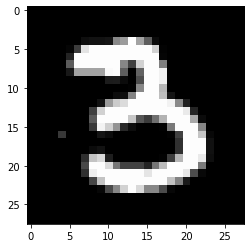

In [39]:
#Lets visualizate a example
index = 120
sample_img = X_train[index, :, :, :]
plt.imshow(sample_img, cmap = "gray")

In [40]:
#Let's obtain some interesting data
n_train = X_train.shape[0]
n_val = X_val.shape[0]

print(n_train)

33600


In [41]:
# Defining the bath size and putting in variables the rest of the data.
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
IMAGE_CHANNELS = 1
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)

BATCH_SIZE = n_train/258

#Model

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

## Data augmentation

Let's modify the data slightly to create new and perhaps more complicated examples for the model to train. Once the model has been trained and the cases in which the model fails, it will return to this step and the changes made will be modified.

(33600, 28, 28, 1)
(33600, 28, 28, 1)


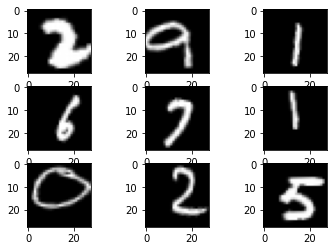

In [43]:
train_datagen = ImageDataGenerator(
      rescale=1/255,
      rotation_range = 15,
      width_shift_range = 0.15,
      height_shift_range = 0.15,
      zoom_range = 0.2)

train_gen = train_datagen.flow(X_train, y_train, batch_size = n_train)

for X_batch, y_batch in train_gen:
# create a grid of 3x3 images
    print(np.shape(X_batch))
    print(np.shape(X_train))
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break
    

print(train_gen)

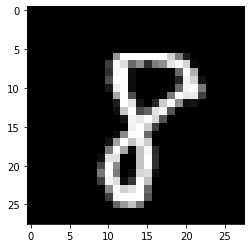

In [44]:
index = 10
sample_img = X_train[index, :, :, :]
plt.imshow(sample_img, cmap = "gray")

[0 0 0 0 0 1 0 0 0 0]


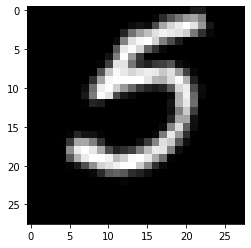

In [45]:
sample_img = X_batch[index, :, :, :]
print(y_batch[index])
plt.imshow(sample_img, cmap = "gray")

##Early stopping

Let's define early stoping to save time and resources if the model is not improving.

In [46]:
early_stopping = EarlyStopping(
    monitor = "val_loss", 
    min_delta = 0.0008, 
    patience = 15, 
    restore_best_weights = True, 
    verbose = 1
)

callbacks = [early_stopping]

## Model

Let's try with a normal model and see how valid it is.

In [57]:
model = Sequential([
  Conv2D(filters = 64, kernel_size = (5,5), padding = "same", input_shape = IMAGE_SIZE),
  Activation("relu"),
  MaxPooling2D(),
  Dropout(0.45),
  Conv2D(filters = 128, kernel_size = (5, 5), padding = "same"),
  Activation("relu"),
  MaxPooling2D(),
  Dropout(0.45),
  Flatten(),
  Dense(256),
  Activation("relu"),
  Dropout(0.45),
  Dense(64),
  Activation("relu"),
  Dropout(0.45),
  Dense(10, activation = "softmax"),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
activation_8 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
activation_9 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 128)        

In [58]:
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [59]:
Model1=model.fit(
    x = X_batch,
    y= y_batch,
    steps_per_epoch = n_train// BATCH_SIZE,
    epochs = 100, 
    validation_data = (X_val, y_val), 
    callbacks = callbacks
)

Epoch 1/100
257/257 [==============================] - 103s 399ms/step - loss: 1.6428 - accuracy: 0.4086 - val_loss: 20.4836 - val_accuracy: 0.9625
Epoch 2/100
257/257 [==============================] - 102s 395ms/step - loss: 0.3995 - accuracy: 0.8802 - val_loss: 11.7406 - val_accuracy: 0.9798
Epoch 3/100
257/257 [==============================] - 101s 395ms/step - loss: 0.2661 - accuracy: 0.9247 - val_loss: 9.9396 - val_accuracy: 0.9824
Epoch 4/100
257/257 [==============================] - 101s 393ms/step - loss: 0.2112 - accuracy: 0.9426 - val_loss: 9.1733 - val_accuracy: 0.9818
Epoch 5/100
257/257 [==============================] - 101s 395ms/step - loss: 0.1719 - accuracy: 0.9519 - val_loss: 8.0398 - val_accuracy: 0.9858
Epoch 6/100
257/257 [==============================] - 102s 396ms/step - loss: 0.1490 - accuracy: 0.9589 - val_loss: 8.6673 - val_accuracy: 0.9854
Epoch 7/100
257/257 [==============================] - 102s 398ms/step - loss: 0.1361 - accuracy: 0.9621 - val_loss:

# Training loss and accuracy graphs

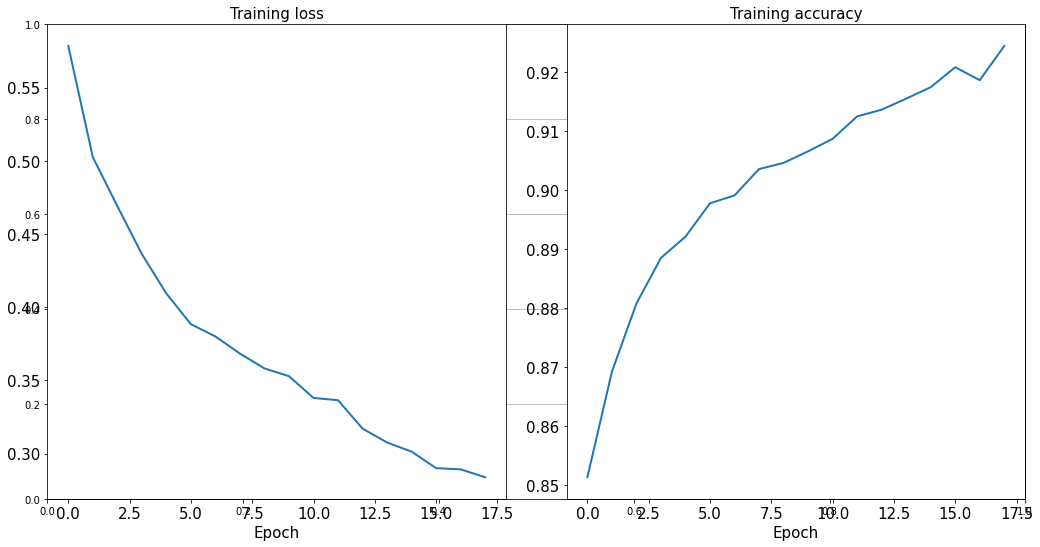

In [51]:
hist = Model1.history
fig, ax = plt.subplots(figsize = (15,8))   
ax.grid(True)
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=2)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=2)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()

## Prediction

With the trained model let's see if predictions match with the real data.

In [61]:
predictions = model.predict(X_val)
print(predictions)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [62]:
predictions = model.predict(X_test)
print(predictions)

predictions = np.argmax(predictions, axis = 1)
print(predictions)

[[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]]
[2 0 9 ... 3 9 2]


In [63]:
yyy_val = yy_val.values
print(yyy_val)

predictions_val = model.predict(X_val)
predictions_val = np.argmax(predictions_val, axis = 1)
print(predictions_val)

[3 6 9 ... 2 7 2]
[3 6 9 ... 2 7 2]


# Error analisys

In [64]:
from sklearn.datasets import make_classification
import seaborn as sns
from sklearn.metrics import confusion_matrix

## General

Let's see a resume of the data.

Text(0.5, 1.0, 'Confusion Matrix')

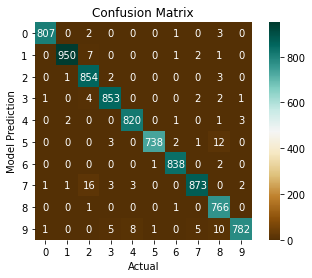

In [65]:
mat = confusion_matrix(yyy_val,predictions_val)

axes = sns.heatmap(mat,square=True, annot=True,fmt='d',
                   cbar=True, cmap=plt.cm.BrBG)

class_labels = ['0','1','2','3','4','5','6','7','8','9' ]

axes.set_xlabel('Actual')
axes.set_ylabel('Model Prediction')

tick_marks = np.arange(len(class_labels)) + 0.5

axes.set_xticks(tick_marks)
axes.set_xticklabels(class_labels,rotation=0)

axes.set_yticks(tick_marks)
axes.set_yticklabels(class_labels,rotation=0)

axes.set_title('Confusion Matrix')

The more usual confusion are: 7 with 2; 9 with 4 and 1 with 7. This numbers can seem similar at first glance in many cases.

## Specific

Let's see some examples of misclassification and look for a patron.

The prediction was:  8  and the label  9


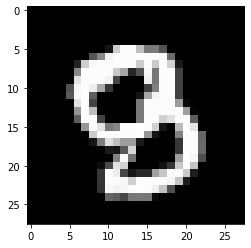

The prediction was:  9  and the label  7


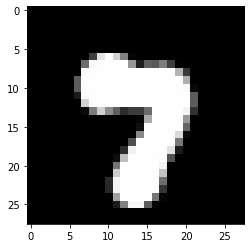

The prediction was:  3  and the label  2


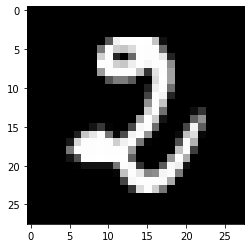

The prediction was:  2  and the label  7


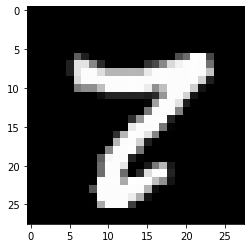

The prediction was:  2  and the label  1


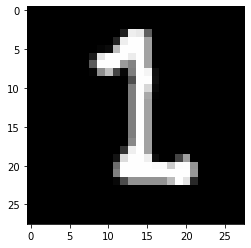

The prediction was:  8  and the label  5


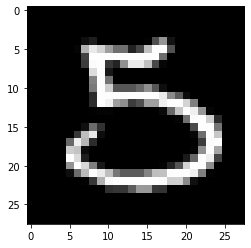

The prediction was:  6  and the label  1


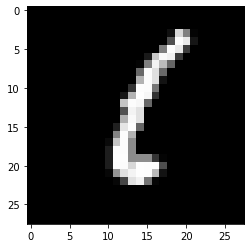

The prediction was:  0  and the label  9


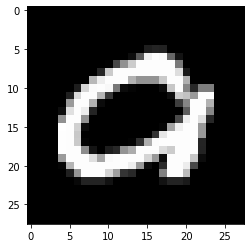

The prediction was:  6  and the label  5


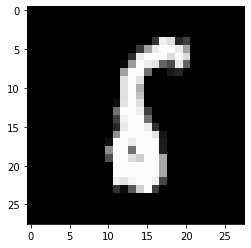

The prediction was:  3  and the label  7


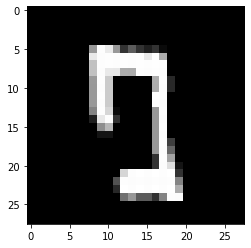

The prediction was:  8  and the label  6


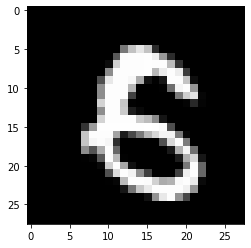

The prediction was:  3  and the label  5


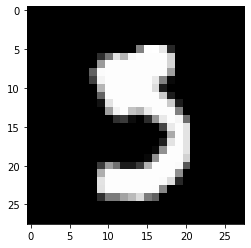

The prediction was:  8  and the label  2


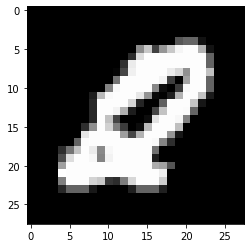

The prediction was:  8  and the label  6


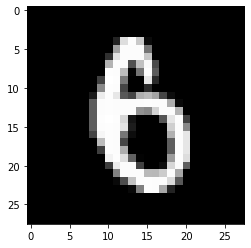

The prediction was:  2  and the label  7


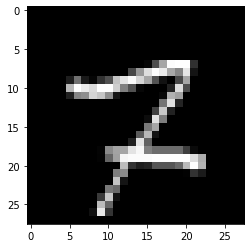

The prediction was:  4  and the label  7


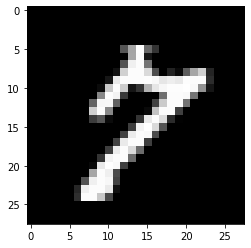

The prediction was:  7  and the label  9


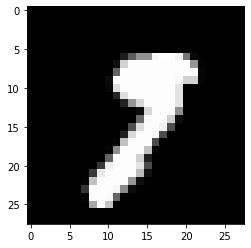

The prediction was:  2  and the label  7


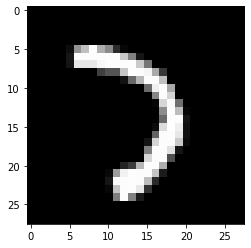

The prediction was:  9  and the label  4


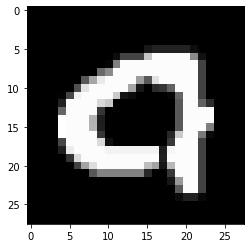

The prediction was:  8  and the label  9


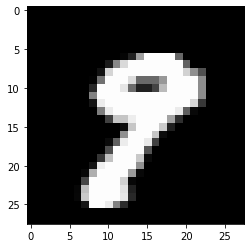

The prediction was:  4  and the label  9


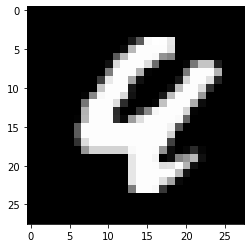

The prediction was:  4  and the label  9


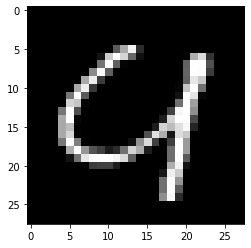

The prediction was:  2  and the label  1


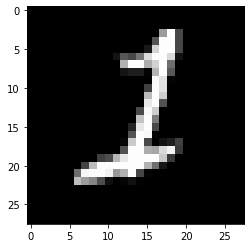

The prediction was:  4  and the label  9


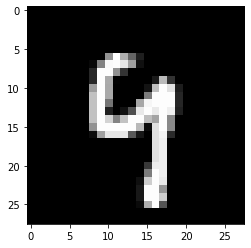

The prediction was:  2  and the label  1


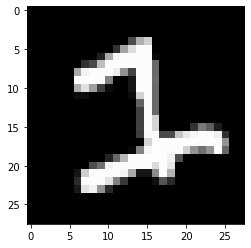

The prediction was:  4  and the label  9


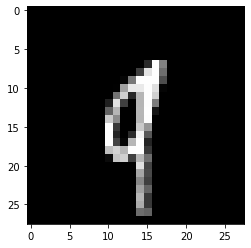

The prediction was:  2  and the label  7


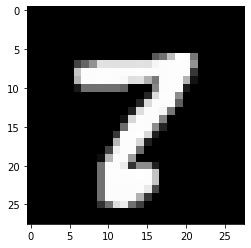

The prediction was:  3  and the label  9


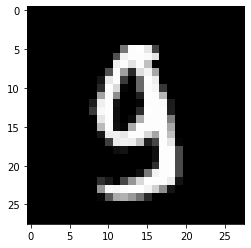

The prediction was:  8  and the label  5


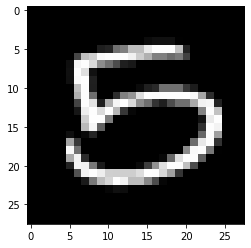

The prediction was:  4  and the label  9


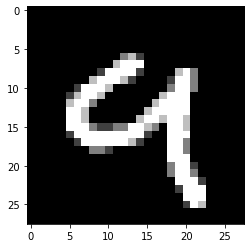

The prediction was:  8  and the label  5


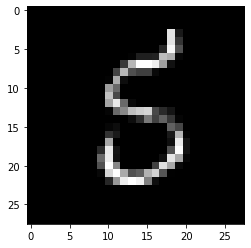

The prediction was:  8  and the label  5


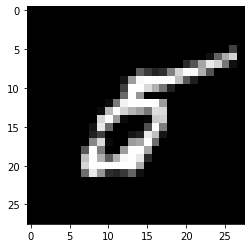

The prediction was:  8  and the label  0


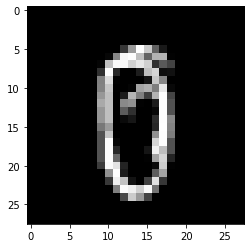

The prediction was:  6  and the label  5


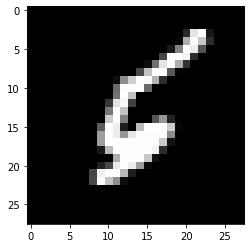

The prediction was:  9  and the label  7


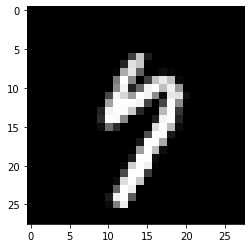

The prediction was:  8  and the label  9


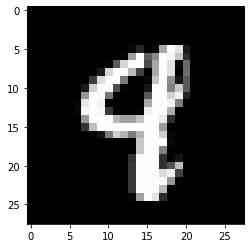

The prediction was:  3  and the label  5


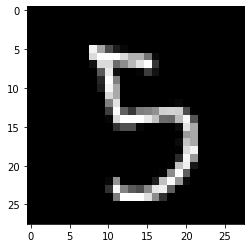

The prediction was:  8  and the label  1


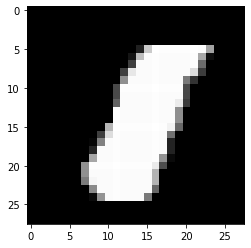

The prediction was:  2  and the label  3


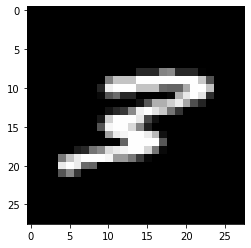

The prediction was:  7  and the label  1


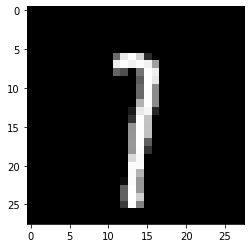

The prediction was:  7  and the label  3


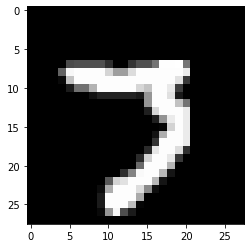

The prediction was:  4  and the label  7


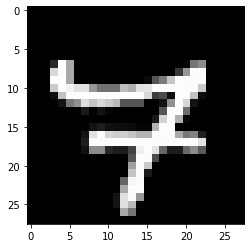

The prediction was:  1  and the label  4


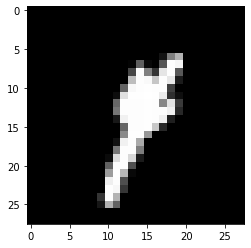

The prediction was:  8  and the label  2


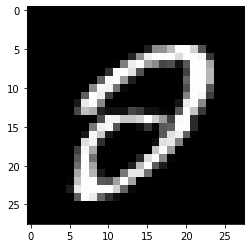

The prediction was:  8  and the label  0


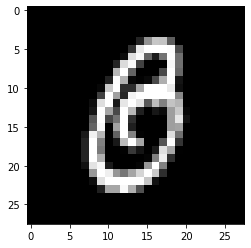

The prediction was:  8  and the label  9


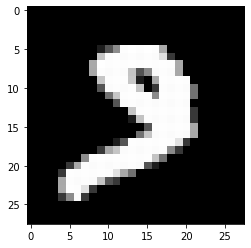

The prediction was:  2  and the label  7


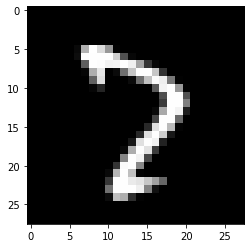

The prediction was:  6  and the label  4


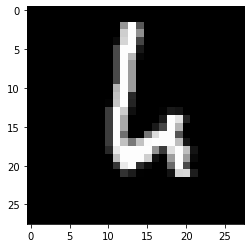

The prediction was:  3  and the label  2


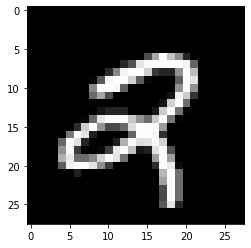

The prediction was:  3  and the label  7


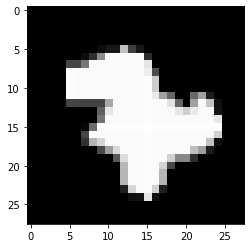

The prediction was:  2  and the label  7


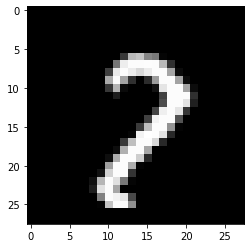

The prediction was:  4  and the label  9


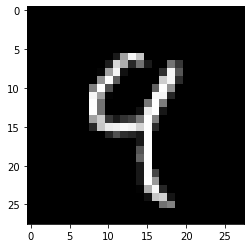

The prediction was:  2  and the label  3


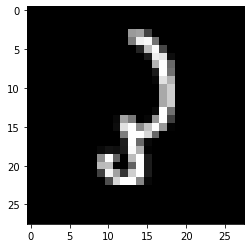

The prediction was:  8  and the label  5


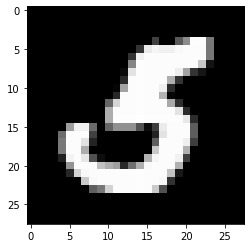

The prediction was:  2  and the label  1


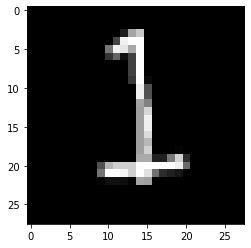

The prediction was:  6  and the label  8


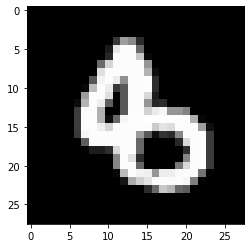

The prediction was:  2  and the label  7


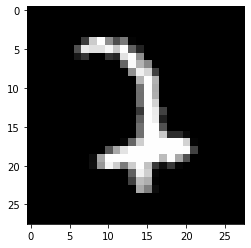

The prediction was:  2  and the label  8


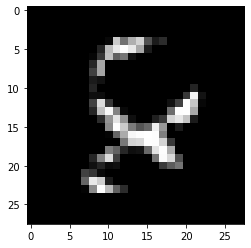

The prediction was:  3  and the label  9


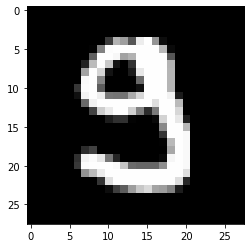

The prediction was:  8  and the label  3


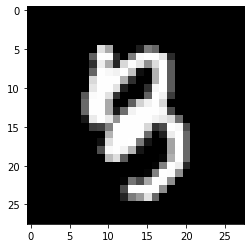

The prediction was:  5  and the label  9


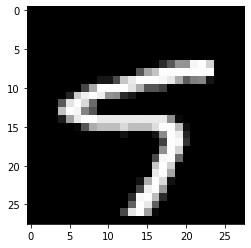

The prediction was:  2  and the label  1


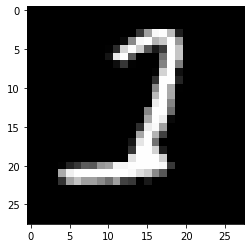

The prediction was:  6  and the label  0


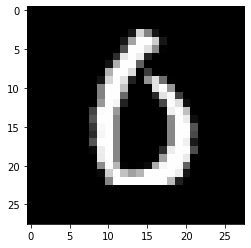

The prediction was:  2  and the label  7


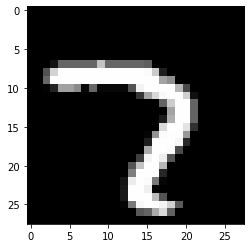

The prediction was:  8  and the label  5


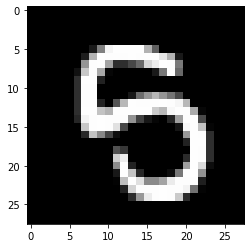

The prediction was:  4  and the label  9


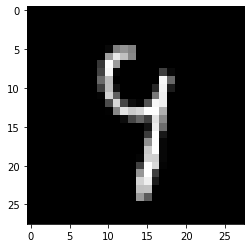

The prediction was:  2  and the label  3


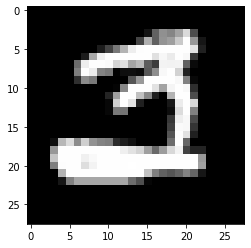

The prediction was:  7  and the label  9


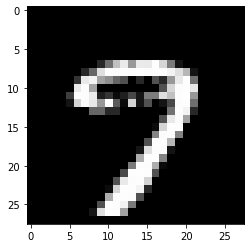

The prediction was:  0  and the label  3


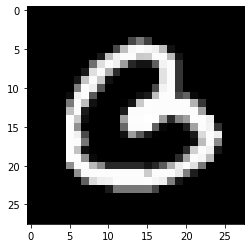

The prediction was:  2  and the label  7


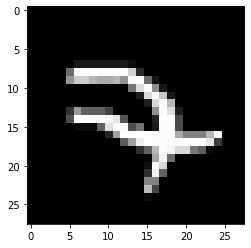

The prediction was:  2  and the label  7


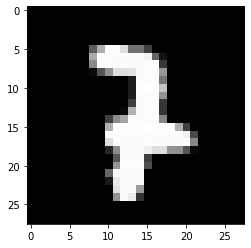

The prediction was:  8  and the label  5


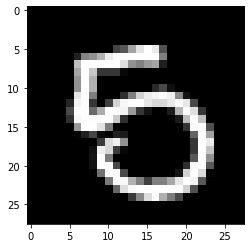

The prediction was:  3  and the label  9


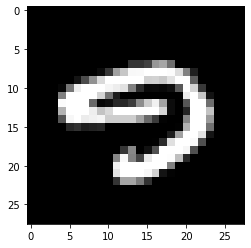

The prediction was:  2  and the label  7


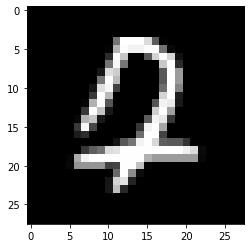

The prediction was:  9  and the label  4


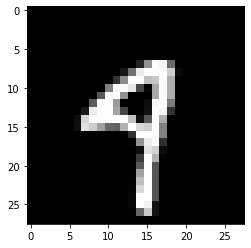

The prediction was:  5  and the label  6


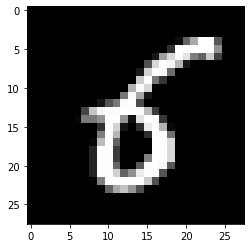

The prediction was:  2  and the label  7


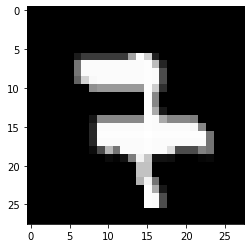

The prediction was:  2  and the label  0


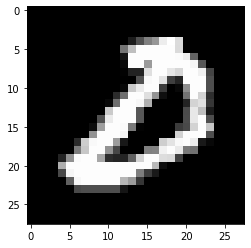

The prediction was:  7  and the label  5


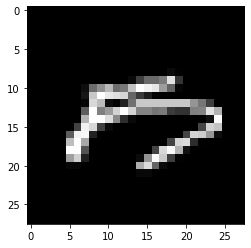

The prediction was:  7  and the label  3


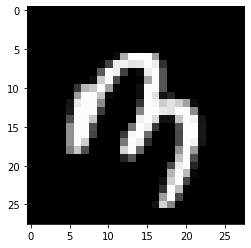

The prediction was:  2  and the label  7


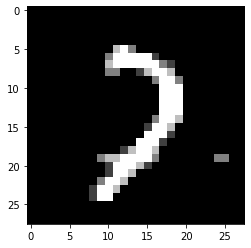

The prediction was:  3  and the label  7


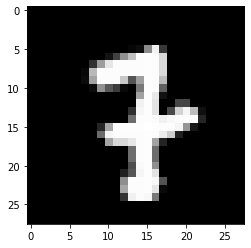

The prediction was:  1  and the label  4


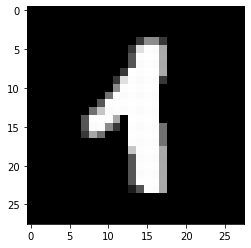

The prediction was:  7  and the label  9


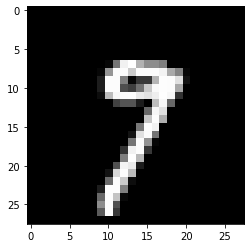

The prediction was:  2  and the label  3


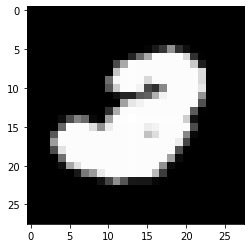

The prediction was:  3  and the label  9


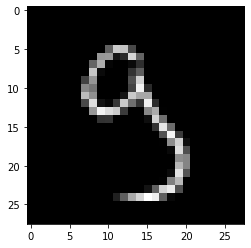

The prediction was:  8  and the label  9


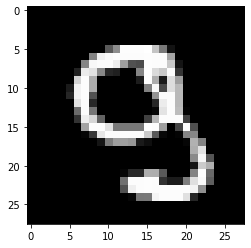

The prediction was:  8  and the label  5


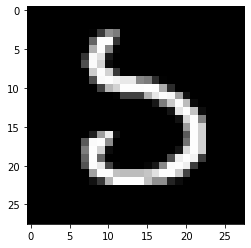

The prediction was:  9  and the label  4


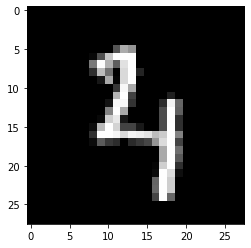

The prediction was:  8  and the label  5


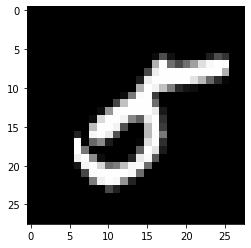

The prediction was:  8  and the label  3


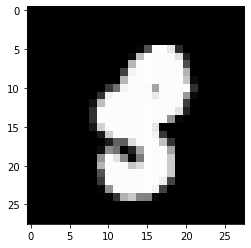

The prediction was:  1  and the label  7


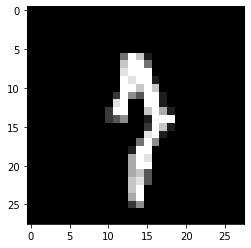

The prediction was:  7  and the label  9


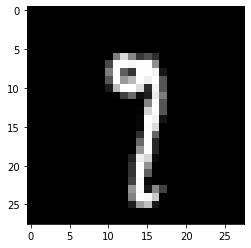

The prediction was:  3  and the label  9


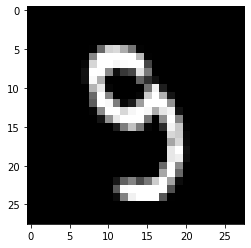

The prediction was:  8  and the label  9


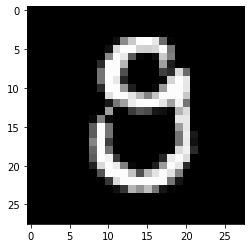

The prediction was:  2  and the label  0


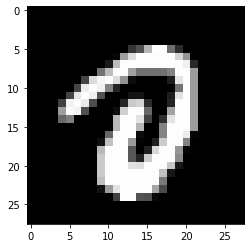

The prediction was:  1  and the label  2


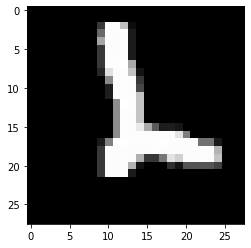

The prediction was:  4  and the label  9


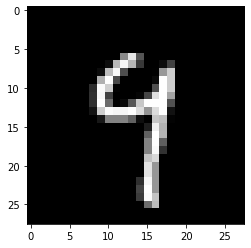

The prediction was:  2  and the label  1


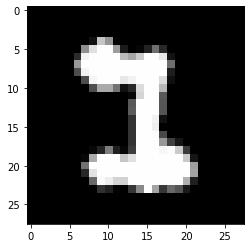

The prediction was:  8  and the label  9


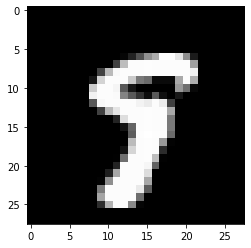

The prediction was:  0  and the label  7


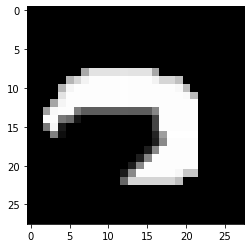

The prediction was:  8  and the label  2


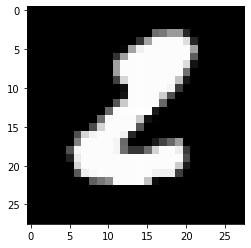

The prediction was:  8  and the label  5


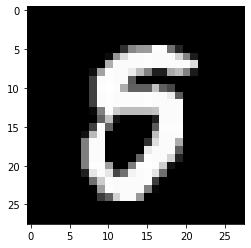

The prediction was:  8  and the label  4


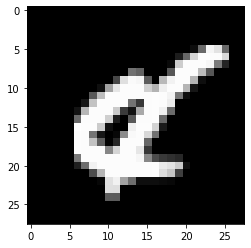

The prediction was:  2  and the label  7


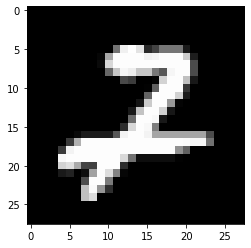

The prediction was:  4  and the label  7


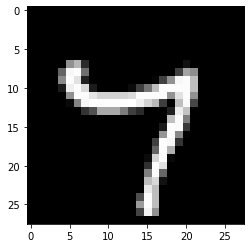

The prediction was:  2  and the label  7


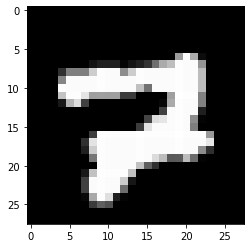

The prediction was:  8  and the label  0


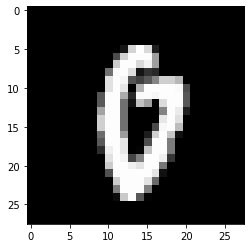

The prediction was:  8  and the label  9


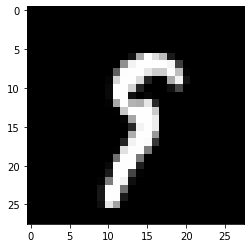

The prediction was:  8  and the label  5


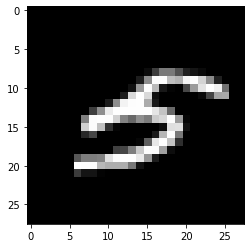

The prediction was:  3  and the label  5


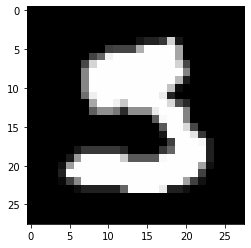

The prediction was:  8  and the label  5


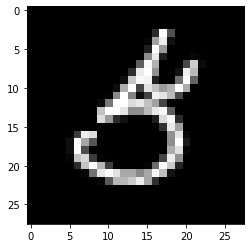

The prediction was:  7  and the label  1


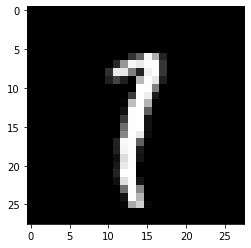

The prediction was:  8  and the label  9


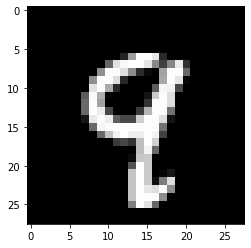

The prediction was:  7  and the label  9


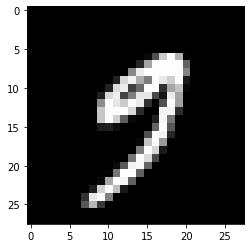

The prediction was:  8  and the label  9


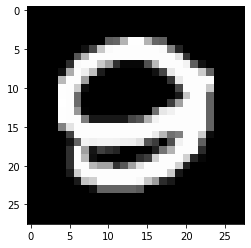

The prediction was:  9  and the label  3


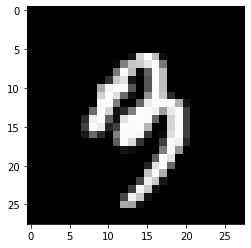

The prediction was:  2  and the label  7


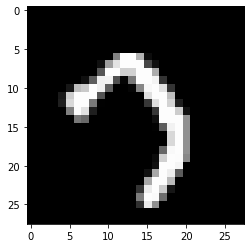

The prediction was:  2  and the label  1


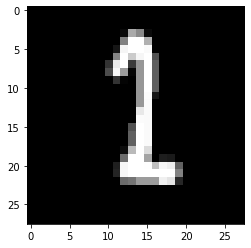

0


In [66]:

for index in range (len(yyy_val)):
    i=0
    if yyy_val[index] != predictions_val[index]:
        i=i+1
        print ("The prediction was: ", predictions_val[index], " and the label ", yyy_val[index])
        sample_img = X_val[index, :, :, :]
        plt.imshow(sample_img, cmap = "gray")       
        plt.show()

print(i)

In [ ]:
Example["Label"]=predictions
#test["Survived"]=model_Y['Union_discrete']
Result=Example


#Obtein the file
Result.to_csv('my_submission3.csv', index=False)

## Results
In this markdown I'm showing the progres of my model.

### Iteration 0: Baseline
Goal: My Baseline is the percentage of numbers that I would classification by chance. As all number are almost equally represented that proportion is 10%.
 + Validation accuracy = 0.10
 
Conclusion: Whatever model which results are equal or worse than the baseline is almost worthless.




### Iteration 1: Firt simple model
Goal: In this first model the goal is to create a structure to be improved, take into account some of the variables and obtain a model to which incremental improvements are added.
 + Validation accuracy = 0.9872
 + Test accuracy = 0.9880 
 
Conclusion: It is a very good result. I think it can improve if more epochs are allowed.




### Iteration 2: More epochs
Goal: Lets try with more epochs.
 + Validation accuracy = 0.9883
 + Test accuracy = 0.9887 
 
Conclusion: It is a small improvement, but the model is now much more slower. There is not much room for improvement in this area.  Lets observate the mismatched data and look for a patron




### Iteration 3: Searching in the mismatches
Goal: Identificate patrons in the mismatched data. 
 
Conclusion: I couldn't identificate most of the numbers by myself so this  competition is over for now.